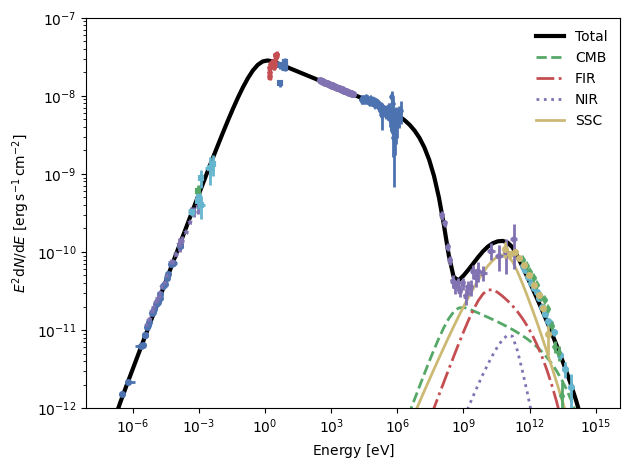

In [20]:
import astropy.units as u
import numpy as np
from astropy.constants import c
from astropy.io import ascii

import naima
from naima.models import (
    ExponentialCutoffBrokenPowerLaw,
    InverseCompton,
    Synchrotron,
)

ECBPL = ExponentialCutoffBrokenPowerLaw(
    amplitude=3.699e36 / u.eV,
    e_0=1 * u.TeV,
    e_break=0.265 * u.TeV,
    alpha_1=1.5,
    alpha_2=3.233,
    e_cutoff=1863 * u.TeV,
    beta=2.0,
)

eopts = {"Eemax": 50 * u.PeV, "Eemin": 0.1 * u.GeV}

SYN = Synchrotron(ECBPL, B=125 * u.uG, Eemax=50 * u.PeV, Eemin=0.1 * u.GeV)

# Compute photon density spectrum from synchrotron emission assuming R=2.1 pc
Rpwn = 2.1 * u.pc
Esy = np.logspace(-7, 9, 100) * u.eV
Lsy = SYN.flux(Esy, distance=0 * u.cm)  # use distance 0 to get luminosity
phn_sy = Lsy / (4 * np.pi * Rpwn**2 * c) * 2.24

IC = InverseCompton(
    ECBPL,
    seed_photon_fields=[
        "CMB",
        ["FIR", 70 * u.K, 0.5 * u.eV / u.cm**3],
        ["NIR", 5000 * u.K, 1 * u.eV / u.cm**3],
        ["SSC", Esy, phn_sy],
    ],
    Eemax=50 * u.PeV,
    Eemin=0.1 * u.GeV,
)

# Use plot_data from naima to plot the observed spectra
data = ascii.read("../data/CrabNebula/CrabNebula_spectrum.ecsv")
figure = naima.plot_data(data, e_unit=u.eV)
ax = figure.axes[0]

# Plot the computed model emission
energy = np.logspace(-7, 15, 100) * u.eV
ax.loglog(
    energy,
    IC.sed(energy, 2 * u.kpc) + SYN.sed(energy, 2 * u.kpc),
    lw=3,
    c="k",
    label="Total",
)
for i, seed, ls in zip(range(4), ["CMB", "FIR", "NIR", "SSC"], ["--", "-.", ":", "-"]):
    ax.loglog(
        energy,
        IC.sed(energy, 2 * u.kpc, seed=seed),
        lw=2,
        c=naima.plot.color_cycle[i + 1],
        label=seed,
        ls=ls,
    )


ax.set_ylim(1e-12, 1e-7)
ax.legend(loc="upper right", frameon=False)
figure.tight_layout()
# figure.savefig("CrabNebula_SynSSC.png")

Naima uses multiprocessing to do parallel computing during the fitting!! 

Note for multiprocessing: Functionality within this package [multiprocessing] requires that the __main__ module be importable by the children. This is covered in Programming guidelines however it is worth pointing out here. This means that some examples, such as the multiprocessing.pool.Pool examples will not work in the interactive interpreter. i.e. this may give problems using jupyter notebook.

To solve this problem, we have to the code as a script: nested multiprocessing code in `if __name__ == '__main'__`


In [21]:
%%writefile CrabNebula_SynIC.py
# magic command to write the content of the cell to a file

import astropy.units as u
import numpy as np
from astropy.io import ascii
from astropy.table import vstack
import naima
from naima.models import ExponentialCutoffBrokenPowerLaw, InverseCompton, Synchrotron
import astropy.units as u
import numpy as np
from astropy.constants import c
from astropy.io import ascii
import os
import naima
from naima.models import (
    ExponentialCutoffBrokenPowerLaw,
    InverseCompton,
    Synchrotron,
)


def SYN_ICmodel(pars, data):
    amplitude = 10**pars[0] / u.eV
    e_break=(10 ** pars[1]) * u.TeV
    alpha_1=pars[2]
    alpha_2=pars[3]
    e_cutoff = (10 ** pars[4]) * u.GeV

    ECBPL = ExponentialCutoffBrokenPowerLaw(
        amplitude=amplitude,
        e_0=1 * u.TeV,
        e_break=e_break,
        alpha_1=alpha_1,
        alpha_2=alpha_2,
        e_cutoff=e_cutoff,
        beta=2.0,
    )

    SYN = Synchrotron(ECBPL, B=125 * u.uG, Eemax=50 * u.PeV, Eemin=0.1 * u.GeV)

    # Compute photon density spectrum from synchrotron emission assuming R=2.1 pc
    Rpwn = 2.1 * u.pc
    Esy = np.logspace(-7, 9, 100) * u.eV
    Lsy = SYN.flux(Esy, distance=0 * u.cm)  # use distance 0 to get luminosity
    phn_sy = Lsy / (4 * np.pi * Rpwn**2 * c) * 2.24

    IC = InverseCompton(
        ECBPL,
        seed_photon_fields=[
            "CMB",
            ["FIR", 70 * u.K, 0.5 * u.eV / u.cm**3],
            ["NIR", 5000 * u.K, 1 * u.eV / u.cm**3],
            ["SSC", Esy, phn_sy],
        ],
    )
    return IC.flux(data, 2 * u.kpc) + SYN.flux(data, distance=2 * u.kpc)


def lnprior(pars):
    # Limit amplitude to positive domain
    logprob = naima.uniform_prior(pars[0], 0, np.inf) + naima.normal_prior(pars[2],1.5,0.2) + naima.normal_prior(pars[3],3.2,0.2)
               
    return logprob


if __name__ == '__main__':

    p0 = np.array((np.log10(3.699e36), np.log10(0.265), 1.5, 3.233, np.log10(1863)))
    labels = ["log10(norm)", "log10(e_break)","alpha_1", "alpha_2", "log10(cutoff)"]
    data = ascii.read("../data/CrabNebula/CrabNebula_spectrum.ecsv")


    os.system("rm CrabNebula_results/Crab_SynIC*")

    ## Run sampler
    sampler, pos = naima.run_sampler(
        data_table=data,
        p0=p0,
        labels=labels,
        model=SYN_ICmodel,
        prior=lnprior,
        nwalkers=32,
        nburn=10,
        nrun=30,
        # threads=4,
        prefit=True,
        interactive=False,
    )

    # Save run results to HDF5 file (can be read later with naima.read_run)
    out_root = "CrabNebula_results/Crab_SynIC"
    naima.save_run(out_root+".hdf5", sampler)

    ## Save diagnostic plots and results table
    naima.save_diagnostic_plots(out_root, sampler, sed=True)
    naima.save_results_table(out_root, sampler) 

Overwriting CrabNebula_SynIC.py


In [22]:
import subprocess
subprocess.run(["python","CrabNebula_SynIC.py"])

INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [36.7883492  -0.57675413  1.5         3.233       3.27021285] [naima.core]
INFO:    Initial lnprob(p0): -625169.396 [naima.core]
INFO:    New ML parameters : [35.89333453 -0.19715596  1.76144374  3.25056755  6.19628255] [naima.core]
INFO: flat prior lnprob(p0): -2590.602 [naima.core]
INFO: full prior lnprob(p0): -2592.036 [naima.core]
Burning in the 32 walkers with 10 steps...

Progress of the run: 0 percent (0 of 10 steps)
                           --log10(norm)-- log10(e_break)- ----alpha_1---- ----alpha_2---- -log10(cutoff)-
  Last ensemble median :      35.9           -0.197           1.77            3.25            6.19      
  Last ensemble std    :      0.173          0.00112         0.00751         0.0139          0.0331     
  Last ensemble lnprob :  avg: -105464.655, max: -2682.615

Progress of the run: 10 percent (1 of 10 steps)
                           --l

INFO: Plotting Model output 0... [naima.analysis]


INFO:astropy:Plotting Model output 0...
/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/site-packages/naima/analysis.py:163: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  f.clf()
INFO:astropy:Plotting Model output 1...
INFO:astropy:Saving results table in CrabNebula_results/Crab_SynIC_results.ecsv
Exception ignored in: <function Pool.__del__ at 0x1427ef740>
Traceback (most recent call last):
  File "/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/multiprocessing/pool.py", line 271, in __del__
  File "/Users/aaguasca/anaconda3/envs/naima_handson/lib/python3.11/multiprocessing/queues.py", line 371, in put
AttributeError: 'NoneType' object has no attribute 'dumps'


INFO: Plotting Model output 1... [naima.analysis]
INFO: Saving results table in CrabNebula_results/Crab_SynIC_results.ecsv [naima.analysis]


CompletedProcess(args=['python', 'CrabNebula_SynIC.py'], returncode=0)

In [23]:
from astropy.table import Table
file=f"CrabNebula_results/Crab_SynIC.hdf5"
run=naima.read_run(file, modelfn=None)
tab=Table.read(f"CrabNebula_results/Crab_SynIC_results.ecsv")


In [24]:
tab

label,median,unc_lo,unc_hi
str14,float64,float64,float64
log10(norm),35.89270345292445,0.013855564454964053,0.005238471977975223
norm,7.810942718553914e+35,2.4526410944339926e+34,9.47863141170494e+33
log10(e_break),-0.1973031615569355,0.0005039071811766271,0.0003600126031090556
e_break,0.6348875904956754,0.000736225840088256,0.0005265143960974106
alpha_1,1.764032977660798,0.0038750753832450524,0.004146465359504026
alpha_2,3.2507247350823856,0.002859784441504587,0.002483267656829824
log10(cutoff),6.198555137555219,0.02137147220968405,0.035750532515400835
cutoff,1579629.3296353281,75851.41064807819,135534.7393836989
blob1,nan,nan,nan


In [25]:
ECBPL = ExponentialCutoffBrokenPowerLaw(
    amplitude=tab["median"][1] / u.eV,
    e_0=1 * u.TeV,
    e_break=tab["median"][3] * u.TeV,
    alpha_1=tab["median"][4],
    alpha_2=tab["median"][5],
    e_cutoff=tab["median"][7] * u.TeV,
    beta=2.0,
)

eopts = {"Eemax": 50 * u.PeV, "Eemin": 0.1 * u.GeV}

SYN = Synchrotron(ECBPL, B=125 * u.uG, Eemax=50 * u.PeV, Eemin=0.1 * u.GeV)

# Compute photon density spectrum from synchrotron emission assuming R=2.1 pc
Rpwn = 2.1 * u.pc
Esy = np.logspace(-7, 9, 100) * u.eV
Lsy = SYN.flux(Esy, distance=0 * u.cm)  # use distance 0 to get luminosity
phn_sy = Lsy / (4 * np.pi * Rpwn**2 * c) * 2.24

IC = InverseCompton(
    ECBPL,
    seed_photon_fields=[
        "CMB",
        ["FIR", 70 * u.K, 0.5 * u.eV / u.cm**3],
        ["NIR", 5000 * u.K, 1 * u.eV / u.cm**3],
        ["SSC", Esy, phn_sy],
    ],
    Eemax=50 * u.PeV,
    Eemin=0.1 * u.GeV,
)


/var/folders/6q/tl1wg8017xs4pf9yz9kp0zrw0000gn/T/ipykernel_15887/1447273141.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


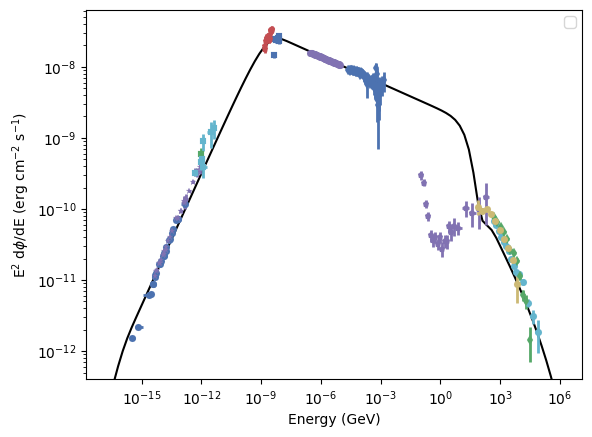

In [26]:
import matplotlib.pyplot as plt

fig=naima.plot_data(run, e_unit=u.GeV)
ax = fig.axes[0]

ax.xaxis.units = u.GeV
ax.yaxis.units = u.Unit("erg s-1 cm-2")
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
# spec_model.plot(ax=ax, sed_type="e2dnde",energy_bounds=[xmin*u.GeV,xmax*u.GeV],color="k",
                    # label=r"Best-fit ($pp\rightarrow \pi_0 \rightarrow \gamma \gamma$)")
ax.set_ylim((ymin, ymax))
ax.set_ylabel(f"E$^2$ d$\phi$/dE (erg cm$^{{-2}}$ s$^{{-1}}$)")
ax.set_xlabel(f"Energy (GeV)")    
ax.legend()
photon_energy=np.geomspace(xmin,xmax,100)*u.GeV
plt.loglog(photon_energy,IC.sed(photon_energy, 2 * u.kpc) + SYN.sed(photon_energy, distance=2 * u.kpc),color="k")